In [2]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
path = "../../Result_json/"
file_list = os.listdir(path)
airflow_files = [file for file in file_list if file.startswith("airflow")]
airbyte_files = [file for file in file_list if file.startswith("airbyte")]

# Sort list
airflow_files = sorted(airflow_files)
airbyte_files = sorted(airbyte_files)

In [4]:
source, target, status = [], [], []
for file, lst in zip(airflow_files, [source, target, status]):
    with open(path + file) as f:
        for line in f:
            temp_json = json.loads(line)
            temp_json['framework'] = "Airflow + Spark"
            lst.append(temp_json)
            
for file, lst in zip(airbyte_files, [source, target]):
    with open(path + file) as f:
        for line in f:
            temp_json = json.loads(line)
            temp_json['framework'] = "Airbyte"
            lst.append(temp_json)        
            
            
status_airbyte = []
with open(path + airbyte_files[-1]) as f:
    for line in f:
        temp_json = json.loads(line)
        temp_json['framework'] = "Airbyte"
        status_airbyte.append(temp_json)                     

In [5]:
source = pd.DataFrame.from_dict(source, orient='columns').explode(["tables_names", "rows_count", "total_size_bytes"]).reset_index(drop=True)
target = pd.DataFrame.from_dict(target, orient='columns').explode(["tables_names", "rows_count", "total_size_bytes"]).reset_index(drop=True)
status = pd.DataFrame.from_dict(status, orient='columns')
status_airbyte = pd.DataFrame.from_dict(status_airbyte, orient='columns')

display(source.head(3))
display(target.head(3))
display(status.head(3))
display(status_airbyte.head(3))

,benchmark_id,operation,start_time,end_time,sf,tables_names,rows_count,total_size_bytes,framework
0,MjAyMzExMDcwNTAyNTM=,populate_db,1.699333e+09,1.699333e+09,3,cashtransaction,361856,41123840,Airflow + Spark
1,MjAyMzExMDcwNTAyNTM=,populate_db,1.699333e+09,1.699333e+09,3,dailymarket,1282768,98738176,Airflow + Spark
2,MjAyMzExMDcwNTAyNTM=,populate_db,1.699333e+09,1.699333e+09,3,date,25933,7364608,Airflow + Spark


,benchmark_id,sf,tables_names,rows_count,total_size_bytes,framework
0,MjAyMzExMDcwNTAyNTM=,3,cashtransaction,361856,40656896,Airflow + Spark
1,MjAyMzExMDcwNTAyNTM=,3,dailymarket,1282768,98263040,Airflow + Spark
2,MjAyMzExMDcwNTAyNTM=,3,date,25933,6889472,Airflow + Spark


,benchmark_id,startTime,endTime,TimeDelta,operation,framework
0,MjAyMzExMDcwNTAyNTM=,2023-11-07T05:03:13.571586+00:00,2023-11-07T05:04:20.665711+00:00,67.09,sync_airflow,Airflow + Spark
1,MjAyMzExMDcwNTA0MjI=,2023-11-07T05:04:47.069180+00:00,2023-11-07T05:06:09.670705+00:00,82.60,sync_airflow,Airflow + Spark
2,MjAyMzExMDcwNTA2MTE=,2023-11-07T05:06:40.889903+00:00,2023-11-07T05:08:19.038347+00:00,98.15,sync_airflow,Airflow + Spark


,jobId,jobType,startTime,bytesSynced,rowsSynced,TimeDelta,Throughput,operation,benchmark_id,framework
0,123,sync,2023-11-07 13:58:54,6.107011e+08,4525390.0,192,23569.74,sync_airbyte,MjAyMzExMDcxMzU4MjA=,Airbyte
1,125,sync,2023-11-07 14:02:49,8.317040e+08,6160471.0,252,24446.31,sync_airbyte,MjAyMzExMDcxNDAyMDk=,Airbyte
2,127,sync,2023-11-07 14:07:47,1.043358e+09,7779939.0,327,23791.86,sync_airbyte,MjAyMzExMDcxNDA3MDU=,Airbyte


In [6]:
# Source Fix types
source.rows_count = source.rows_count.astype(int)
source.total_size_bytes = source.total_size_bytes.astype(np.int64)
source.start_time = pd.to_datetime(source.start_time, unit='s')
source.end_time = pd.to_datetime(source.end_time, unit='s')
# Target Fix types
target.rows_count = target.rows_count.astype(int)
target.total_size_bytes = target.total_size_bytes.astype(np.int64)
# Source fix types
status.startTime = pd.to_datetime(status.startTime.str.replace("+00:00", ""), format="%Y-%m-%dT%H:%M:%S.%f")
status.endTime = pd.to_datetime(status.endTime.str.replace("+00:00", ""), format="%Y-%m-%dT%H:%M:%S.%f")
# status_airbyte fix types
status_airbyte.startTime = pd.to_datetime(status_airbyte.startTime, format="%Y-%m-%d %H:%M:%S")

# Source create time_delta
source["time_delta"] = (source.end_time - source.start_time).dt.total_seconds()


In [7]:
source_grouped = source.groupby(["framework", "benchmark_id", "sf"]).agg({"rows_count": "sum", "total_size_bytes": "sum", "time_delta": "max"}).reset_index()
target_grouped = target.groupby(["framework", "benchmark_id", "sf"]).agg({"rows_count": "sum", "total_size_bytes": "sum"}).reset_index()

# join source and status
target_status = target[["framework", "benchmark_id", "sf"]].merge(status, left_on=["framework", "benchmark_id"], right_on=["framework", "benchmark_id"], how="inner")
target_status = target_status.groupby(["framework", "benchmark_id", "sf"]).TimeDelta.max().reset_index()
# join source and status aibyte
target_status_airbyte = target[["framework", "benchmark_id", "sf"]].merge(status_airbyte, left_on=["framework", "benchmark_id"], right_on=["framework", "benchmark_id"], how="inner")
target_status_airbyte = target_status_airbyte.groupby(["framework", "benchmark_id", "sf"]).TimeDelta.max().reset_index()

source_status_combined = pd.concat([target_status, target_status_airbyte])

# Calculate Aiflow + Spark Throughput
temp_join = target_status.merge(target_grouped, left_on=["framework", "benchmark_id", "sf"], right_on=["framework", "benchmark_id", "sf"], how="inner")
temp_join["Throughput"] = temp_join.rows_count / temp_join.TimeDelta
temp_join = temp_join[['framework', 'benchmark_id' , "sf", 'TimeDelta', 'Throughput']]

# target_grouped
df_throughput = status_airbyte[['benchmark_id', 'TimeDelta', 'framework']].merge(target_grouped, left_on=["framework", "benchmark_id"], right_on=["framework", "benchmark_id"], how="inner")
df_throughput['Throughput'] = df_throughput.rows_count / df_throughput.TimeDelta
df_throughput = pd.concat([temp_join, df_throughput])

display(source_grouped.head(3))
display(target_status.head(3))

,framework,benchmark_id,sf,rows_count,total_size_bytes,time_delta
0,Airbyte,MjAyMzExMDcxMzU4MjA=,3,4525390,413368320,17.896000
1,Airbyte,MjAyMzExMDcxNDA3MDU=,5,7779939,704872448,25.865250
2,Airbyte,MjAyMzExMDcxNDAyMDk=,4,6160471,562806784,23.860181


,framework,benchmark_id,sf,TimeDelta
0,Airflow + Spark,MjAyMzExMDcwNTA0MjI=,4,82.60
1,Airflow + Spark,MjAyMzExMDcwNTA2MTE=,5,98.15
2,Airflow + Spark,MjAyMzExMDcwNTA4MjA=,6,114.84


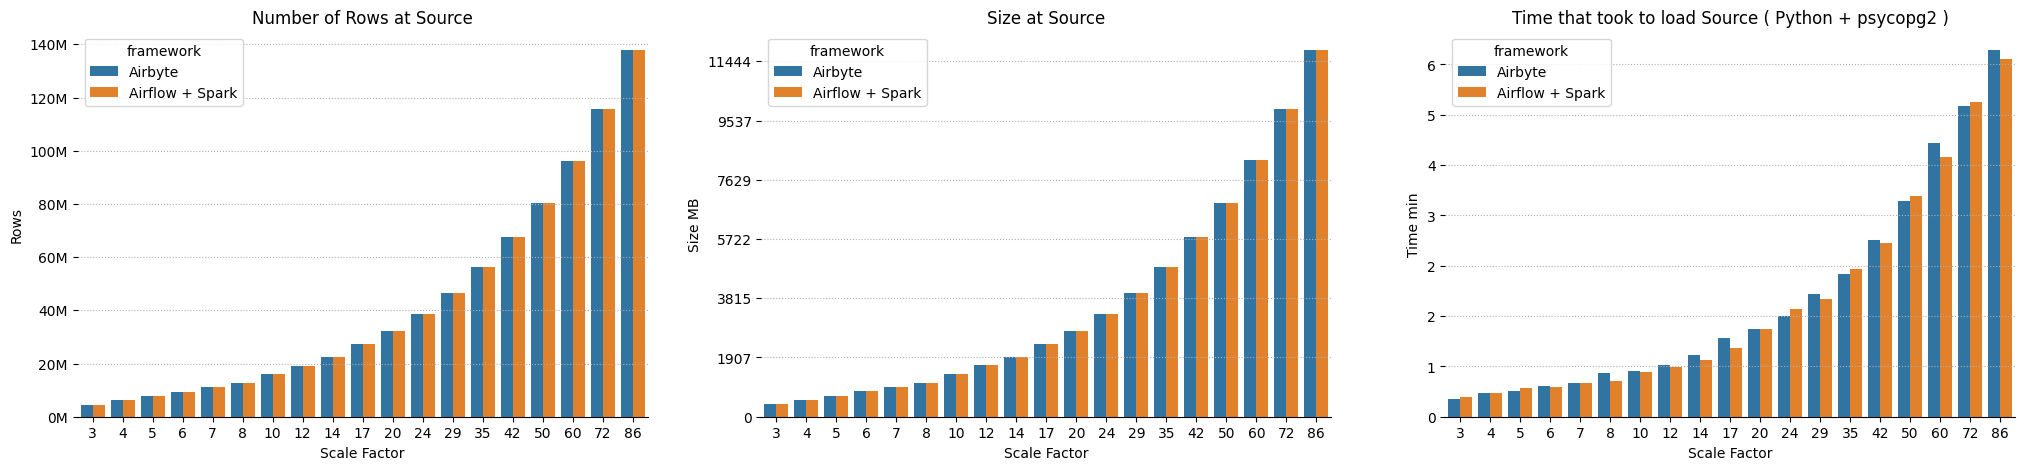

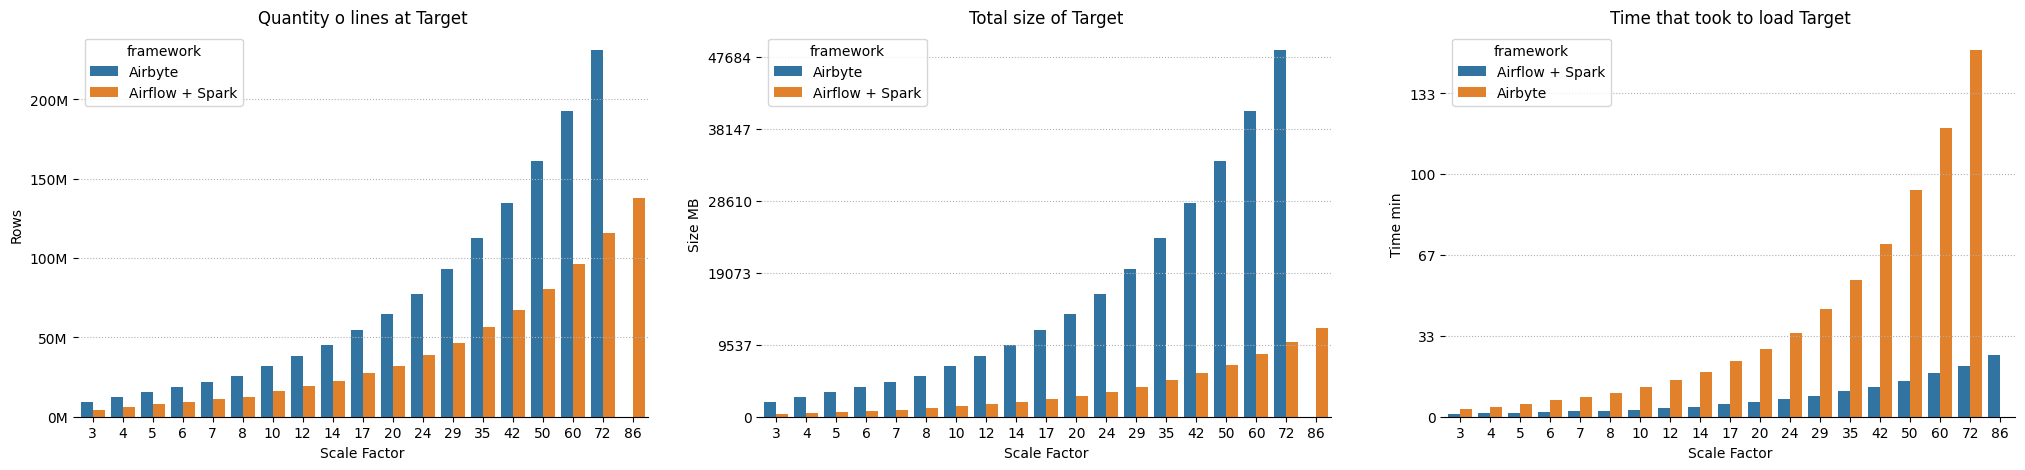

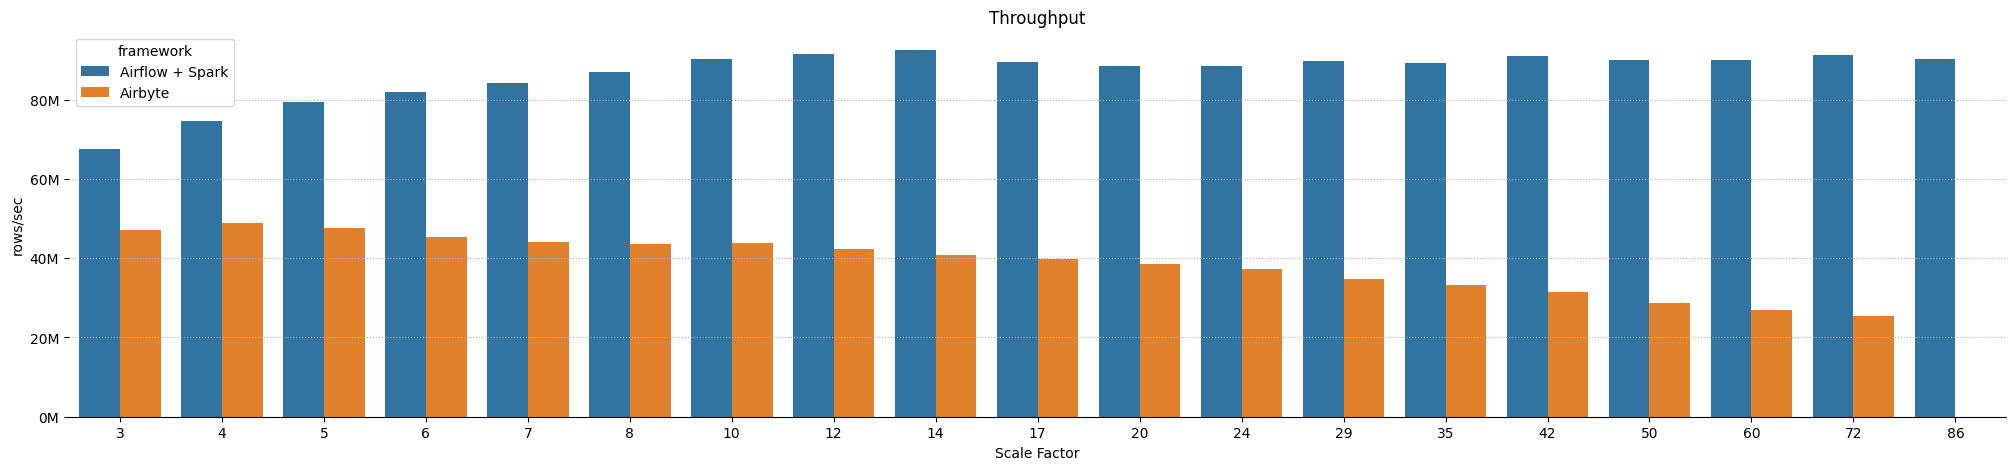

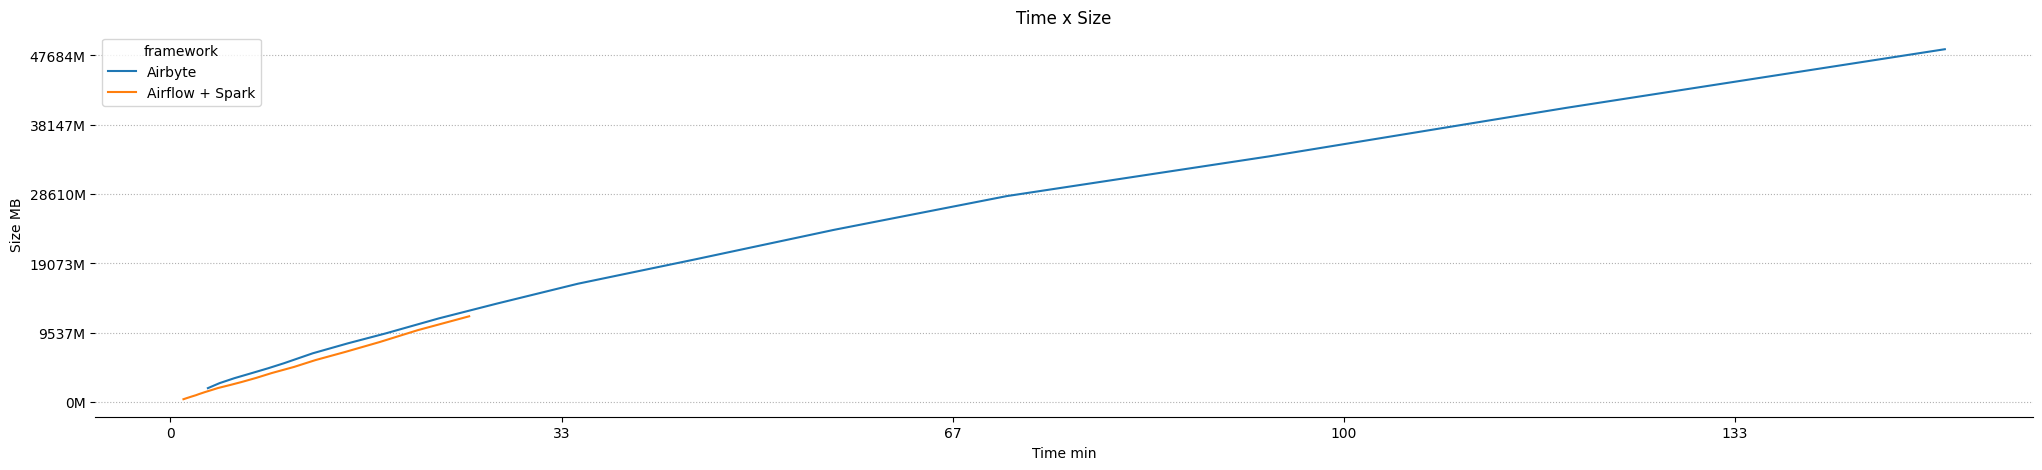

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
# sns.barplot(x="sf", y="time_delta", color="green", data=python_df, ax=ax[2])
for idx, col in enumerate(["rows_count", "total_size_bytes", "time_delta"]):
    g = sns.barplot(x="sf", y=col, hue="framework", data=source_grouped, ax=ax[idx])
    if idx == 0:
        # Set y-axis scale to millions with separators
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1000000) + 'M')
        ax[idx].set(ylabel="Rows", xlabel="Scale Factor", title="Number of Rows at Source")
    elif idx == 1:
        # Set y-axis frequency to rise by 2000 until 14000
        # ax[idx].yaxis.set_major_locator(range(0, 14000, 2000))
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1024/1024))
        ax[idx].set(ylabel="Size MB", xlabel="Scale Factor", title='Size at Source')
    else:
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/60))
        ax[idx].set(ylabel="Time min", xlabel="Scale Factor", title="Time that took to load Source ( Python + psycopg2 )")
    ax[idx].grid(axis='y', linestyle=':')
sns.despine(left=True)
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(25, 5))
for idx, col in enumerate(["rows_count", "total_size_bytes"]):
    sns.barplot(x="sf", y=col, hue="framework", data=target_grouped, ax=ax[idx])
    if idx == 0:
        # Set y-axis scale to millions with separators
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1000000) + 'M')
        ax[idx].set(ylabel="Rows", xlabel="Scale Factor", title="Quantity o lines at Target")
    else:
        # Divide by 1024 to get MB
        ax[idx].yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1024/1024))
        ax[idx].set(ylabel="Size MB", xlabel="Scale Factor", title="Total size of Target")
    ax[idx].grid(axis='y', linestyle=':')
# sns.despine(left=True)
# plt.show()

# fig, ax = plt.subplots(figsize=(25, 5))
sns.barplot(x="sf", y="TimeDelta", hue="framework", data=source_status_combined, ax=ax[2])
# Set y-axis scale to millions with separators
ax[2].yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/60))
ax[2].set(ylabel="Time min", xlabel="Scale Factor", title="Time that took to load Target")
ax[2].grid(axis='y', linestyle=':')
sns.despine(left=True)
plt.show()

fig, ax = plt.subplots(figsize=(25, 5))
sns.barplot(x="sf", y="Throughput", hue="framework", data=df_throughput, ax=ax)
# Set y-axis scale to millions with separators
ax.yaxis.set_major_formatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'M')
ax.set(ylabel="rows/sec", xlabel="Scale Factor", title="Throughput")
ax.grid(axis='y', linestyle=':')
sns.despine(left=True)
plt.show()

temp_df = target_grouped.merge(source_status_combined, left_on=["framework", "benchmark_id", "sf"], right_on=["framework", "benchmark_id", "sf"], how="inner")

fig, ax = plt.subplots(figsize=(25, 5))
sns.lineplot(x="TimeDelta", y="total_size_bytes", hue="framework", data=temp_df, ax=ax)
# Set y-axis scale to millions with separators
ax.yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1024/1024) + 'M')
ax.xaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/60))
ax.set(ylabel="Size MB", xlabel="Time min", title="Time x Size")
ax.grid(axis='y', linestyle=':')
sns.despine(left=True)
plt.show()

# Post Analisys

In [1]:
from prometheus_api_client import PrometheusConnect
from datetime import timedelta

In [2]:
url = 'http://localhost:9090'
# Connect
prom = PrometheusConnect(url=url, disable_ssl=True)

my_metrics = [
    "node_cpu_seconds_total", # Seconds the CPUs spent in each mode
    "node_filesystem_avail_bytes", # Filesystem space available to non-root users in bytes.
    "node_filesystem_size_bytes", # Filesystem size in bytes.
    "node_memory_Buffers_bytes", # Memory information field Buffers_bytes.
    "node_memory_Cached_bytes", # Memory information field Cached_bytes.
    'node_memory_SReclaimable_bytes',
    'node_memory_MemFree_bytes',
    'node_memory_MemTotal_bytes',
    "pg_stat_database_tup_deleted",
    "pg_stat_database_tup_fetched",
    "pg_stat_database_tup_inserted",
    "pg_stat_database_tup_returned",
    "pg_stat_database_tup_updated",
    "pg_database_size_bytes"
]

In [206]:
status_fixed_time = status.copy()
status_fixed_time = status_fixed_time.merge(target_grouped, left_on=["framework", "benchmark_id"],
                                            right_on=["framework", "benchmark_id"], how="inner")

cols = ['benchmark_id', 'startTime', 'TimeDelta', "operation", "framework", "sf", "rows_count", "total_size_bytes"]
status_fixed_time = pd.concat([status_fixed_time, status_airbyte.merge(target_grouped, left_on=["framework", "benchmark_id"], right_on=["framework", "benchmark_id"], how="inner")[cols]])

mask = status_fixed_time.endTime.isnull()
status_fixed_time.loc[mask, "endTime"] = status_fixed_time.loc[mask, "startTime"] + status_fixed_time.loc[mask, "TimeDelta"].apply(lambda x: timedelta(seconds=x))
status_fixed_time.reset_index(drop=True, inplace=True)
status_fixed_time.startTime = status_fixed_time.startTime - timedelta(hours=3)
status_fixed_time.endTime = status_fixed_time.endTime - timedelta(hours=3)

status_fixed_time.tail(3)

,benchmark_id,startTime,endTime,TimeDelta,operation,framework,sf,rows_count,total_size_bytes
25,MjAyMzExMDcxNDQxNTU=,2023-11-07 11:42:57,2023-11-07 11:55:05,728.0,sync_airbyte,Airbyte,10,31860866,7034552320
26,MjAyMzExMDcxNDU1Mjg=,2023-11-07 11:56:43,2023-11-07 12:11:50,907.0,sync_airbyte,Airbyte,12,38365302,8466612224
27,MjAyMzExMDcxNTEyMjE=,2023-11-07 12:13:56,2023-11-07 12:32:17,1101.0,sync_airbyte,Airbyte,14,44893174,9904881664


In [213]:
# from prometheus_api_client.utils import parse_datetime
# from prometheus_api_client import MetricsList, Metric,  MetricSnapshotDataFrame, MetricRangeDataFrame

temp_row = status_fixed_time.iloc[27]

start_time = temp_row.startTime
end_time = temp_row.endTime
# chunk_size = timedelta(seconds=60)

# qry = "node_filesystem_size_bytes{instance='TARGET', job='node_exporter', device!~'rootfs'} - \
#      node_filesystem_avail_bytes{instance='TARGET', job='node_exporter', device!~'rootfs'}"

qry = 'pg_database_size_bytes{datname="tpc", instance="TARGET"}'
metric_data = prom.custom_query_range(
    query=qry,  # this is the metric name and label config
    start_time=start_time - timedelta(minutes=20),
    end_time=end_time,
    step="1m"
)
# import numpy as np
# temp = pd.DataFrame(metric_data[0]['values'], columns=["time", "value"]).astype({"value": np.int64})
# temp.value = temp.value / 1024 / 1024
# temp.time = pd.to_datetime(temp.time, unit='s')
# temp.plot(x="time", y="value", figsize=(25, 5))

print(start_time, end_time, sep="\n")

2023-11-07 12:13:56
2023-11-07 12:32:17


In [214]:
metric_data

[{'metric': {'__name__': 'pg_database_size_bytes',
   'datname': 'tpc',
   'instance': 'TARGET',
   'job': 'psql_exporter'},
  'values': [[1699358036, '21429064163'],
   [1699358096, '21429064163'],
   [1699358156, '3374010851'],
   [1699358216, '5685678563'],
   [1699358276, '5685711331'],
   [1699358336, '7012094435'],
   [1699358396, '11561464291'],
   [1699358456, '14806200803'],
   [1699358516, '14806266339'],
   [1699358576, '14806364643'],
   [1699358636, '14806421987'],
   [1699358696, '14806295055'],
   [1699358756, '14806454755'],
   [1699358816, '14806454755'],
   [1699358876, '14806454755'],
   [1699358936, '14806454755'],
   [1699358996, '14806454755'],
   [1699359056, '14806454755'],
   [1699359116, '14806454755'],
   [1699359176, '14806454755'],
   [1699359236, '14806454755'],
   [1699359296, '14806454755'],
   [1699359356, '14806454755'],
   [1699359416, '14806454755'],
   [1699359476, '14806454755'],
   [1699359536, '14806454755'],
   [1699359596, '14806454755'],
   [1

In [152]:
12374482944/1024/1024

11801.2265625

<Axes: xlabel='timestamp'>

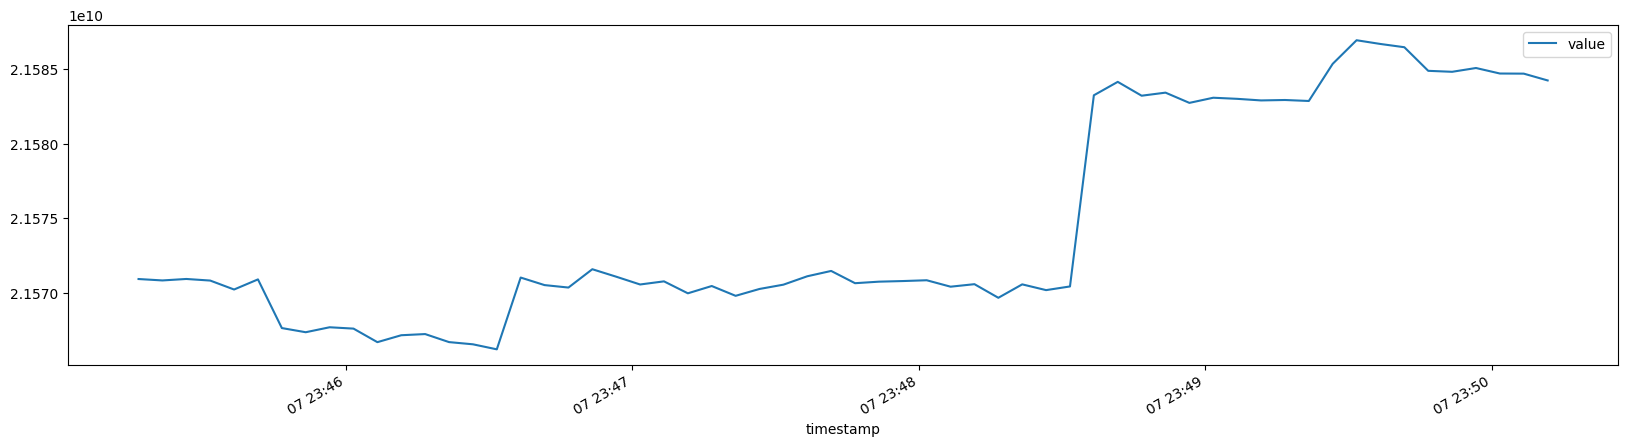

In [8]:
metric_df.plot(y='value', figsize=(20, 5))

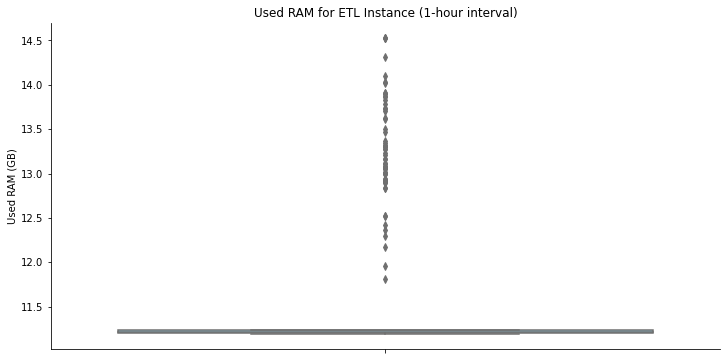

In [12]:
import datetime
from prometheus_api_client import PrometheusConnect
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prometheus URL
prometheus_url = "http://localhost:9090"

# Prometheus API client setup
prometheus_api = PrometheusConnect(prometheus_url, disable_ssl=True)

# Define the query for used RAM for the "ETL" instance
query = 'node_memory_MemTotal_bytes - node_memory_MemFree_bytes'

# Calculate the start and end time for the 1-hour data collection
end_time = datetime.datetime.now()
start_time = end_time - datetime.timedelta(hours=1)

# Query Prometheus for data
data = prometheus_api.custom_query_range(query, start_time, end_time, step='15s')

# Convert the data to a Pandas DataFrame
df = pd.DataFrame(data[0]['values'], columns=['timestamp', 'used_ram'])
df.used_ram = df.used_ram.astype(int)/1024/1024/1024
# Convert the timestamp to a datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Plot the data using Seaborn
# sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, y='used_ram', color='skyblue')
plt.title('Used RAM for ETL Instance (1-hour interval)')
plt.ylabel('Used RAM (GB)')
# plt.tight_layout()
sns.despine()
# Display the plot
plt.show()


In [13]:
data

[{'metric': {'instance': 'ETL', 'job': 'node_exporter'},
  'values': [[1699388595, '12036956160'],
   [1699388610, '12037214208'],
   [1699388625, '12039020544'],
   [1699388640, '12034891776'],
   [1699388655, '12034891776'],
   [1699388670, '12035149824'],
   [1699388685, '12035149824'],
   [1699388700, '12035923968'],
   [1699388715, '12036182016'],
   [1699388730, '12036182016'],
   [1699388745, '12035923968'],
   [1699388760, '12036440064'],
   [1699388775, '12035665920'],
   [1699388790, '12035665920'],
   [1699388805, '12036440064'],
   [1699388820, '12036440064'],
   [1699388835, '12036182016'],
   [1699388850, '12036440064'],
   [1699388865, '12036698112'],
   [1699388880, '12036698112'],
   [1699388895, '12036956160'],
   [1699388910, '12037988352'],
   [1699388925, '12040568832'],
   [1699388940, '12040310784'],
   [1699388955, '12040568832'],
   [1699388970, '12040568832'],
   [1699388985, '12040568832'],
   [1699389000, '12040568832'],
   [1699389015, '12040822784'],
   [1